In [15]:
!pip install ultralytics

In [16]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
import ultralytics
from ultralytics import YOLO

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


In [18]:
!ls -R /content/mask_wearing_dataset


/content/mask_wearing_dataset:
README.dataset.txt  README.roboflow.txt  test  train  valid

/content/mask_wearing_dataset/test:
0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg
0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.txt
1224331650_g_400-w_g_jpg.rf.483a35a2395bf48e96783587a59fe876.jpg
1224331650_g_400-w_g_jpg.rf.483a35a2395bf48e96783587a59fe876.txt
126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.jpg
126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.txt
1288126-10255706714jpg_jpg.rf.ed230c79fdbb1fa0650ff4fd32f620ee.jpg
1288126-10255706714jpg_jpg.rf.ed230c79fdbb1fa0650ff4fd32f620ee.txt
15391513324714o1n0r10n6_jpg.rf.eb6b6b796ad74b0c9d75011d1020f0af.jpg
15391513324714o1n0r10n6_jpg.rf.eb6b6b796ad74b0c9d75011d1020f0af.txt
15391513329330sooq10859_jpg.rf.bf9e791012521a572a3a7f2979d0dffe.jpg
15391513329330sooq10859_jpg.rf.bf9e791012521a572a3a7f2979d0dffe.txt
1579924271_jpg.rf.1f

In [19]:
!apt-get install tree


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 3 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (273 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120769 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [20]:
!tree /content/mask_wearing_dataset


/content/mask_wearing_dataset
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── 0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg
│   ├── 0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.txt
│   ├── 1224331650_g_400-w_g_jpg.rf.483a35a2395bf48e96783587a59fe876.jpg
│   ├── 1224331650_g_400-w_g_jpg.rf.483a35a2395bf48e96783587a59fe876.txt
│   ├── 126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.jpg
│   ├── 126202-untitled-design-13_jpg.rf.baa3d2e55d469ae5d5d4cd81c4603e1d.txt
│   ├── 1288126-10255706714jpg_jpg.rf.ed230c79fdbb1fa0650ff4fd32f620ee.jpg
│   ├── 1288126-10255706714jpg_jpg.rf.ed230c79fdbb1fa0650ff4fd32f620ee.txt
│   ├── 15391513324714o1n0r10n6_jpg.rf.eb6b6b796ad74b0c9d75011d1020f0af.jpg
│   ├── 15391513324714o1n0r10n6_jpg.rf.eb6b6b796ad74b0c9d75011d1020f0af.txt
│   ├── 15391513329330sooq10859_jpg.rf.bf9e791012521a572a3a7f2979d0dffe.jpg
│   ├── 15391513329330sooq10859_jpg.rf.bf9

In [21]:
import os

dataset_path = "/content/mask_wearing_dataset"

for split in ["train", "valid", "test"]:
    split_path = os.path.join(dataset_path, split)
    files = os.listdir(split_path)
    print(f"📂 {split} contains:")
    print(files[:10])  # Show first 10 files
    print("-" * 40)


📂 train contains:
['1580128422_jpg.rf.4496b0fe4afc307aa32966c8180bab49.jpg', '1042977068_jpg.rf.ee48a69fd6f710987596e8fdd2eea713.txt', 'RTX7CD4D-e1580252893876_jpg.rf.34b2faf56bf74f6c3edd88422a37355e.txt', 'sdfsdfsfff_jpg.rf.de8549155f84a7f30cd5f9f88f6c58b3.jpg', '1579928067_250120120154270000005e2bca03bf464_jpg.rf.8f9bd39325ed77b8f7d31f4847f1f2bb.jpg', 'pjecDNMmCUQmbDoJx1fdqolnfHtpsfFK8jTA2Ng0wNg_jpeg.rf.001be2b5923d35fa3118de329f14f583.txt', 'PHOTriZgIKIgsnNLdBJG75vj200203_1000x2000_jpg.rf.4dfc80ae4acc533c6120e47dd8e7fb1f.txt', 'shutterstock_289132226_jpg.rf.749c60ddb7bf3d9db9313ff21cb80f77.jpg', '0200b38c89b16c37c5de8e247bb00c2f_jpg.rf.4868c78878c91c2c7cc7062e90de7658.txt', 'so(19)_jpg.rf.97eeeb08001d4cbdb544ac3a57ff5ef3.txt']
----------------------------------------
📂 valid contains:
['r1000019q669394n9qp_jpg.rf.4ea90092a57dfae9753bfdad3193ea2c.txt', '15391513321824spp815on8_jpg.rf.cbea58f57f15ea6ee59970ad58b1cbf4.txt', '025418_springwest005_jpg.rf.9342b3603f02ddb7d28ea4c91f711677.

In [22]:
import os
import shutil

dataset_path = "/content/mask_wearing_dataset"

for split in ["train", "valid", "test"]:
    split_path = os.path.join(dataset_path, split)

    # Create new directories for images and labels
    os.makedirs(f"{split_path}/images", exist_ok=True)
    os.makedirs(f"{split_path}/labels", exist_ok=True)

    # Move files to respective folders
    for file in os.listdir(split_path):
        if file.endswith((".jpg", ".png", ".jpeg")):
            shutil.move(f"{split_path}/{file}", f"{split_path}/images/{file}")
        elif file.endswith(".txt"):
            shutil.move(f"{split_path}/{file}", f"{split_path}/labels/{file}")

print("✅ Dataset is now organized properly!")


✅ Dataset is now organized properly!


In [23]:
data_yaml = """train: /content/mask_wearing_dataset/train/images
val: /content/mask_wearing_dataset/valid/images
test: /content/mask_wearing_dataset/test/images

nc: 2
names: ["without_mask", "with_mask"]
"""

# Save the YAML file
with open("/content/mask_wearing_dataset/data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ data.yaml file created successfully!")


✅ data.yaml file created successfully!


In [24]:
# Dataset Class for YOLOv5 and Faster R-CNN
class MaskDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [26]:
class MaskDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = [f for f in os.listdir(root) if f.endswith((".jpg", ".png", ".jpeg"))] #Filter images with these extensions
        print(f"Found {len(self.images)} images in {root}")  # Print the number of loaded images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [27]:
transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])


In [29]:
import os
import shutil
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class MaskDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        # Ensure root directory exists
        if not os.path.exists(root):
            raise FileNotFoundError(f"The directory '{root}' does not exist.")

        # Filter for image files
        self.images = [
            f for f in os.listdir(root) if f.lower().endswith((".jpg", ".png", ".jpeg"))
        ]

        # Check if any images were found
        if not self.images:
            raise ValueError(f"No image files found in '{root}'. "
                             f"Please ensure the directory contains images with "
                             f"extensions .jpg, .png, or .jpeg.")

        print(f"Found {len(self.images)} images in {root}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.images[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

# Define the correct path to your dataset
dataset_extract_path = "/content/mask_wearing_dataset/train/images"  # Update this path

transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

# Create the dataset and dataloader
dataset = MaskDataset(dataset_extract_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

Found 105 images in /content/mask_wearing_dataset/train/images


In [31]:
yolo_model = YOLO("yolov5s.pt")  # Load pre-trained YOLOv5 model
yolo_model.train(data="/content/mask_wearing_dataset/data.yaml", epochs=10)  # Changed to the path to data.yaml

PRO TIP 💡 Replace 'model=yolov5s.pt' with new 'model=yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov5s.pt, data=/content/mask_wearing_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, sourc

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytics

train: Scanning /content/mask_wearing_dataset/train/labels... 105 images, 0 backgrounds, 0 corrupt: 100%|██████████| 105/105 [00:00<00:00, 1014.49it/s]

train: New cache created: /content/mask_wearing_dataset/train/labels.cache



val: Scanning /content/mask_wearing_dataset/valid/labels... 29 images, 0 backgrounds, 0 corrupt: 100%|██████████| 29/29 [00:00<00:00, 1493.48it/s]

val: New cache created: /content/mask_wearing_dataset/valid/labels.cache


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train5
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.761      3.313      1.488         38        640: 100%|██████████| 7/7 [00:56<00:00,  8.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

                   all         29        162        0.4      0.327      0.322      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.365      1.705       1.19         71        640: 100%|██████████| 7/7 [00:51<00:00,  7.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.32s/it]

                   all         29        162      0.509      0.425      0.511      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.267      1.487      1.119         64        640: 100%|██████████| 7/7 [00:47<00:00,  6.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.03s/it]

                   all         29        162      0.637      0.566      0.579      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.236      1.331      1.113         54        640: 100%|██████████| 7/7 [00:47<00:00,  6.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]

                   all         29        162      0.482      0.701        0.6      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.217      1.084      1.101         51        640: 100%|██████████| 7/7 [00:49<00:00,  7.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.14s/it]

                   all         29        162       0.76       0.72      0.766      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.193      1.056      1.102         41        640: 100%|██████████| 7/7 [00:51<00:00,  7.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.12s/it]

                   all         29        162      0.825      0.755      0.781      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.124     0.9467      1.046         36        640: 100%|██████████| 7/7 [00:50<00:00,  7.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.98s/it]

                   all         29        162      0.663      0.713      0.772      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.082     0.8972      1.047         43        640: 100%|██████████| 7/7 [00:49<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]

                   all         29        162       0.69      0.647      0.777      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.079     0.8052      1.039         53        640: 100%|██████████| 7/7 [00:48<00:00,  6.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]

                   all         29        162      0.768      0.734      0.758      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.083     0.8297      1.039         75        640: 100%|██████████| 7/7 [00:50<00:00,  7.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.10s/it]

                   all         29        162      0.781      0.702      0.782       0.51



10 epochs completed in 0.158 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 18.5MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 18.5MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cpu CPU (Intel Xeon 2.00GHz)
YOLOv5s summary (fused): 84 layers, 9,112,310 parameters, 0 gradients, 23.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]


                   all         29        162      0.826      0.755      0.781       0.52
          without_mask         28        142      0.746      0.761      0.799      0.542
             with_mask          9         20      0.906       0.75      0.763      0.497
Speed: 0.5ms preprocess, 120.4ms inference, 0.0ms loss, 11.2ms postprocess per image
Results saved to runs/detect/train5


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df26cf33390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [32]:
def detect_image(img_path):
    results = yolo_model(img_path)
    results.show()

In [34]:
def detect_image(img_path):
    results = yolo_model(img_path)
    # Check if results is not empty and contains the expected type before calling show()
    if results and isinstance(results[0], ultralytics.yolo.engine.results.Results):
        results[0].show()  # Call show() on the first element if it's a Results object
    else:
        print("No objects detected or unexpected result format.") # Print a message if no objects are detected

In [40]:
!pip install -U ultralytics


In [41]:
from ultralytics import YOLO

# Load the YOLO model (ensure it's correctly initialized)
yolo_model = YOLO("yolov8n.pt")  # Replace with your model

def detect_image(img_path):
    results = yolo_model(img_path)  # Run inference

    # Check if results exist
    if results:
        results[0].show()  # Directly show the first result
    else:
        print("No results found.")


100%|██████████| 6.25M/6.25M [00:00<00:00, 75.4MB/s]


In [43]:
from ultralytics import YOLO

# Load the model
yolo_model = YOLO("yolov8n.pt")  # Ensure the correct model path


In [44]:
print(yolo_model)


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

Running inference on: /content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg

image 1/1 /content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg: 352x640 6 persons, 113.2ms
Speed: 2.5ms preprocess, 113.2ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)
Inference complete.
Results type: <class 'list'>
Results found, displaying...


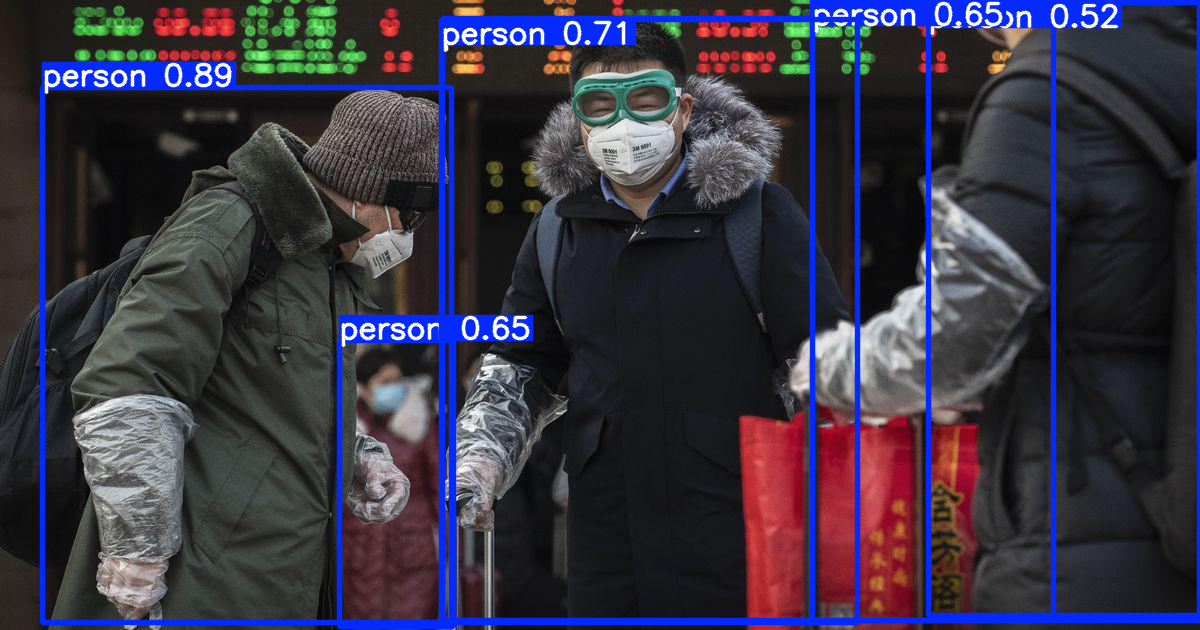

In [46]:
def detect_image(img_path):
    print("Running inference on:", img_path)

    try:
        results = yolo_model(img_path)  # Run YOLOv8 inference
        print("Inference complete.")
        print("Results type:", type(results))

        if results:
            print("Results found, displaying...")
            results[0].show()  # Show results
        else:
            print("No results found.")

    except Exception as e:
        print("Error during inference:", e)

# Call the function
detect_image("/content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg")


In [47]:
img_path = "/content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg"
results = yolo_model(img_path)

print("Results type:", type(results))
print(results)



image 1/1 /content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg: 352x640 6 persons, 37.3ms
Speed: 2.2ms preprocess, 37.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Results type: <class 'list'>
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 

In [48]:
cnn_model = models.resnet50(pretrained=True)
cnn_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 211MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
def extract_features(image_path, model, layers):
    image = Image.open(image_path).convert("RGB")
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(image).unsqueeze(0)

    feature_maps = {}
    def hook_fn(module, input, output):
        feature_maps[module] = output.detach()

    hooks = []
    for layer in layers:
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    with torch.no_grad():
        model(img_tensor)

    for hook in hooks:
        hook.remove()

    for layer, feature_map in feature_maps.items():
        feature_img = feature_map[0].mean(dim=0).numpy()
        feature_img = (feature_img - feature_img.min()) / (feature_img.max() - feature_img.min())
        feature_img = (feature_img * 255).astype(np.uint8)
        # Use cv2_imshow instead of cv2.imshow
        from google.colab.patches import cv2_imshow # Import cv2_imshow from google.colab.patches
        cv2_imshow(feature_img) # Display using cv2_imshow
        cv2.waitKey(0)
        cv2.destroyAllWindows()

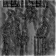

In [52]:
layers_to_extract = [cnn_model.layer1, cnn_model.layer2, cnn_model.layer3]
extract_features("/content/mask_wearing_dataset/test/images/0_Concern-In-China-As-Mystery-Virus-Spreads_jpg.rf.5633f5fe7a9b926101b7fc16615dfb6a.jpg", cnn_model, layers_to_extract)